In [1]:
import string
import math as m
import itertools as iTools
from nupack import *
import matplotlib.pyplot as plt

#defining the toehold switch complex analysis model
thsModel = Model(material = "rna", celsius = 37)

#Filse for storing output
# outputFile = open("triggerComplex.txt", "w")
# outputFile2 = open("toeholdSwitch.txt", "w")

#Dictionary for storing user input
miRNADict = {}
miRNADictVals = []

#dictionary defining complimentary base pairing (no wobble pairing present)
baseDict = {"A":"U", "C":"G"}

#List of bases
baseList = ["A", "U", "C", "G"]

#list of and regions
andRegions = ("AAAAAA", "UUUUUU", "CCCCCC", "GGGGGG")

#complex structure in DU+
complexStructure = []

#strands to be put together in the file
strands = []
orderedStrands = []

#list of domain names for NUPACK
domains = list((string.ascii_lowercase))

#list of complex.seq
seq = []

#number of iterations
iterCount = 0

thsObjs = []

minScoreList = []


class ToeholdSwitch:
    def __init__(self, strucEnergy, toehold, duplex, sequence, exposure, strandsUsed, triggerStruc, thsSamples, triggerSamples):
        self.strucEnergy = strucEnergy
        self.toehold = toehold
        self.duplex = duplex
        self.sequence = sequence
        self.exposure = exposure
        self.strandsUsed = strandsUsed
        self.triggerStruc = triggerStruc
        self.thsSamples = thsSamples
        self.triggerSamples = triggerSamples

    def display(self):
        print(f"this switch has this structure {self.strucEnergy.structure} ({self.strucEnergy.energy}), this toehold {self.toehold}, this duplex {self.duplex}, this sequence {self.sequence}, and this exposure {self.exposure}, using these strands {self.strandsUsed}, with this trigger structure {self.triggerStruc}")
        
#computes complimentary strand
def compStrand(rnaStrand):
    compliment = ""
    for i in rnaStrand:
        for key, value in baseDict.items():
            if i == key:
                compliment += value
            elif i == value:
                compliment += key
    return compliment

#reverses string
def reverse(rnaStrand):
  return rnaStrand[::-1]

#splits each miRNAInput into thirds and adds those to the storageArray
def splitString(miRNAInput):
    storageArray = []
    miRNAInput = miRNAInput.replace(" ","")
    n = round(len(miRNAInput)//3)
    if (len(miRNAInput) == 18):
        part1 = miRNAInput[:n]
        part2 = miRNAInput[2*n+1:]
        part3 = miRNAInput[n:2*n+1]#modified
    else:
        part1 = miRNAInput[:n]
        part2 = miRNAInput[2*n+1:]
        part3 = miRNAInput[n:2*n+1]#modified
    storageArray.append(compStrand(part1))
    storageArray.append(compStrand(part2))
    storageArray.append(part3)#Modified
    return storageArray

#computes and gate
def andGateGen(sequenceDict):
   
    storageArray = []
    miRNAPartArray = []
    global unpairedMiddleArray
    unpairedMiddleArray = []#modified
    # miRNADictVals.extend(list(miRNADict.values()))
 
    #splits the input strands into the required components for genetic switch
    for element in miRNADictVals:
        storageArray = splitString(element)
        miRNAPartArray.append(storageArray[0])
        miRNAPartArray.append(storageArray[1])
        unpairedMiddleArray.append(storageArray[2])#modified

    #makes sure code runs on the end of 1 strand and the beginning of the other
    del miRNAPartArray[0]
    del miRNAPartArray[len(miRNAPartArray)-1]
    middleIndex = 0
    for element in miRNAPartArray:

        if(miRNAPartArray.index(element) % 2==0):
            #index is incrimented later to update the andRegion such that its adjacent base doesn't match itself
            index = 0

            #this sets the default value of the andRegion to AAAAAA
            andRegion = andRegions[index]
           
           
            #these are the parts of the and gates that bind to the toehold switch, specifically those complimentary to the miRNA
            global miRNA1, miRNA2

            miRNA1 = reverse(miRNAPartArray[miRNAPartArray.index(element)])

            miRNA2 = miRNAPartArray[miRNAPartArray.index(element) + 1]  
           
            #checking to see if the andRegion borders an identical base and changing it to correct this by incrimenting the index
            #this only needs to be done twice as in the "worst case scenario", ALL of the below code will run, making the anndRegion different to BOTH of its neighboring bases
            if (miRNA1[-1] == andRegion[1]):
                index += 1
                andRegion = andRegions[index]
            if (reverse(miRNA2)[0] == andRegion[1]):
                index += 1
                andRegion = andRegions[index]
            if (reverse(miRNA2)[0] and miRNA1[-1] == andRegion[1]):
                index += 1
                andRegion = andRegions[index]  

            #defining a repeating unit for the complex
            duplex1 = "D" + str(len(miRNA1)) + "+"
            complexAnd = "U" + str(len(andRegion))
            duplex2 = "D" + str(len(miRNA2)) + "+"
            unpairedMiddle = "U" + str(len(unpairedMiddleArray[middleIndex]))#modified
            # print("WTF THING: ", unpairedMiddleArray[middleIndex])
       
            repeatUnit = [duplex1, complexAnd, duplex2, unpairedMiddle]      
           
            andGateDict = {}
            andGateArray = []
           
            #construcing and gate out of end of 1 miRNA< start of the next one and the AND region in between consisting of 6 repeated bases
            andGate = miRNA1 + andRegion + reverse(miRNA2)
           
            #strands array contains UNORDERED strands, starting with and gates, there will always be 1 fewer and gates than miRNA
            strands.append(andGate)
            middleIndex+=1#modified

 
            complexStructure.extend(repeatUnit)
            # if (len(miRNADictVals) == 3 and len(miRNADictVals[1]) == 18):
            #     print("STUPID MISTAKE: ", complexStructure[3], int(complexStructure[3][-1]))
            #     fix = int(complexStructure[3][-1]) - 1
            #     complexStructure[3] = "U" + str(fix)
            #     print("FIX: ", complexStructure[3])
            #     print("NUPACK DUMB")
        else:
            continue
    if (iterCount > 0):
        strands.extend(miRNADictVals)
   
    if (len(miRNADictVals) == 3 and len(miRNADictVals[1]) == 18):
        fix = int(complexStructure[3][-1]) - 1
        complexStructure[3] = "U" + str(fix)
    # print("Done")

#Ensures correct inputs
def checkCorrectCharacters(characterList, userInput:string):
    userInput = userInput.replace(" ","")
    for element in userInput:
        if(characterList.count(element)==0):
            break
        else:
            return True
    return False

#gets the length of the unpaired start and end.
def unpairedParts(numMiRNA):
    if(numMiRNA == 1):
        print("done")
    else:
        global unpairedStartLength
        # global miRNADictVals
        unpairedStartLength = len(miRNADictVals[0]) - round((len(miRNADictVals[0])//3))

        #this was the annoying thing I was talking about ages ago where due to divisibility by 3 resulting in a number that may round up or down depending on the remainder. fixed by brute force
        if (unpairedStartLength % 3 == 2):
            unpairedStartLength = unpairedStartLength + 1
        elif (unpairedStartLength % 3 == 1):
            unpairedStartLength = unpairedStartLength - 1
        else:
            unpairedStartLength = unpairedStartLength

        #converting unpairedStart and End to DU+ notation and adding to the beginning and end of complexStructure respectively
        if(numMiRNA == 1):
            unpairedStart = "U" + str(unpairedStartLength)
            complexStructure.insert(0, unpairedStart)
        else:
            unpairedStart = "U" + str(unpairedStartLength)
            unpairedEnd = "U" + str(len(miRNADictVals[-1]) - len(miRNA2))
            complexStructure[-1] = unpairedEnd
            complexStructure.insert(0, unpairedStart)

#Combines two lists together into one array so that their constituent variables appear in an alternating sequence (miRNA, AND, miRNA, AND.... miRNA)
def listAddition(array1, array2):
    #dummy element makes the length of the list divisible by 2
    array1.append("DUMMY")
    # array2 = [sub[item] for item in range(len(array1)) for sub in [array2, array1]]
    array2 = [item for sublist in zip(array2, array1) for item in sublist]
    del array2[-1]
    del array1[-1]
   
    return array2
   

def domainOutputs():
    # outputFile = open("triggerComplex.txt", "w")
    seq.clear()
    domainCodes = []

    #this writes the text to be put in the txt file for assigning domains to the DU+ structure, eg
    #domain a = AUCGACGACUGCCGUA
    #domain b = UUCGUAGCUAGCUGA etc...
    for strand, domain in zip(strands, domains):
        domainCode = "domain " + domain + " = " + strand
        domainCodes.append(domainCode)

    #this takes letters of the alphabet in order until there is 1 for each miRNA and AND gate
    global domainsUsed
    domainsUsed = domains[0:len(domainCodes)]
    # print("domainsUsed: ", domainsUsed)

    #the domainsUsed list is split into 2 halves, one with letters to be assigned to miRNAs and the other to AND gates
    mid = int((len(domainsUsed) + 1)/2)
    miRNAs = list(domainsUsed[mid-1:])
    andGates = list(domainsUsed[0:mid-1])

    seq.extend(miRNAs)

    seq.extend(listAddition(andGates, seq))
    del seq[0:len(andGates)+1]
    global computedComplexStructure
    computedComplexStructure = complexStructure
    DUPlusToDPPlus(computedComplexStructure)
    # for sequence in seq:
        # outputFile.write(sequence + " ")

def toeholdSwitchGen(numMiRNA):
   
    #handles creatoion of toehold switch
    #assigning start and end of toeholdRegion
    global orderedStrands
    orderedStrands = listAddition(strands[0:int((len(strands)-1)/2)], strands[int((len(strands)-1)/2):int(len(strands))])
    print("miRNADictVals: ", miRNADictVals)
    print("orderedStrands: ", orderedStrands)
    print("strands: ", strands)
    #this is the unpaired region of the toehold switch where the miRNA complex binds
    toehold = round((len(miRNADictVals[0])//2))
   
    #this is the unpaired part of the toehold switch the miRNA, AND GATE complex would first bind to before the switch unzips
    toeholdRegion = []
   
    if(numMiRNA !=1):
        toeholdStart = miRNADictVals[0][0:unpairedStartLength]
        toeholdEnd = miRNADictVals[-1][len(miRNA2):]
        # print("before reverse: ", orderedStrands)
        # for strand in orderedStrands:
        #     reverse(strand)
        # print("after reverse", orderedStrands)
        thsAnds = []
        thsUnpaired = []
       
        for i,strand in enumerate(orderedStrands):
            #determining AND gates in the strands list, now ordered with listAddition, then determining what AND sections are used, eg AAAAAA, GGGGGG, UUUUUU, CCCCCC and adding them to another list
            if (i % 2 == 1):
                # print(strand, " is an and gate")
                for j in andRegions:
                    if (j in strand):
                        thsAnd = j
                        thsAnds.append(thsAnd)
                        continue
           
            #if it's not an and gate, it must be and miRNA, a distinction is made between first and final miRNA in ordered strand complexes as they will have different armound of bases paired with the switch when compared to middle miRNA
            else:
                # print(strand, " isn't an and gate")
                if (i == 0):
                    # print("first miRNA")
                    for j in andRegions:
                        if j in (orderedStrands[i+1]):
                            #computes the part of the miRNA binding to the switch by finding the and region within the miRNA's corresponding andgate, then taking the corresponding number of bases from the miRNA
                            # print(orderedStrands[i+1].find(j))
                            u = strand[0:len(strand) - orderedStrands[i+1].find(j)]
                            # toeholdRegion.append(u)
                            # print(u)
                            thsUnpaired.append(u)
                            # print(thsUnpaired)
                        else:
                            continue
                    # toeholdRegion.append(strand[0:(.find())])
                elif (i == len(orderedStrands) - 1):
                    # print("last miRNA")
                    for j in andRegions:
                        if j in (orderedStrands[i-1]):
                            # print(reverse(orderedStrands[i-1]).find(j))
                            u = strand[reverse(orderedStrands[i-1]).find(j):len(orderedStrands[i-1])+3]
                            # print(u)
                            thsUnpaired.append(u)
                            # print(thsUnpaired)
                        else:
                            continue
                else:
                    # print("middle miRNA")
                    for j in andRegions:
                        if j in (orderedStrands[i-1]):
                            u1 = reverse(orderedStrands[i-1]).find(j)
                            # print("u1: ", u1)
                        else:
                            continue
                           
                    for j in andRegions:
                        if j in (orderedStrands[i+1]):
                            u2 = orderedStrands[i+1].find(j)
                            # print("u2: ", u2)
                        else:
                            continue
                           
                    # print("start, end: ", u1, " - ", u2)
                    u3 = strand[u1:-u2]
                    # print("strand: ", strand)
                    # print("u3: ", u3)
                    thsUnpaired.append(u3)
                   
                # print(thsUnpaired)
                # print(thsAnds)
       
        #reorders the ang regions used and miRNA binding regions as per listAddition            
        toeholdRegion = (listAddition(thsAnds, thsUnpaired))
       
        # print(toeholdRegion)
        toeholdRegion = "".join(toeholdRegion)
        # print("toehold: ", toeholdRegion)
       
        #length of the unpaired binding region of the thsS
        toehold = 15
        thsDuplex = len(toeholdRegion) - toehold
       
        #thsDuplex is the closed/unzipped part of the switch
        # print("thsDuplex: ", thsDuplex)
       
        # print(toehold, thsDuplex)
       
        if (thsDuplex % 3 == 1):
            thsDuplex = thsDuplex - 1
            toehold +=1
        elif (thsDuplex % 3 ==2):
            thsDuplex +=1
            toehold = toehold -1
           
        # print(toehold, thsDuplex)

    #sequence of the toehold switch
    toeholdSwitchSequence = (compStrand(toeholdRegion) + "GGAUUUGCAAAAAAAAGAGGAGAGUAAAAUG" + reverse(toeholdRegion)[0:thsDuplex] + "AACCUGGCGGCAGCGCAAAAG")
    print(toeholdSwitchSequence)
   
    #the entire switch structure in DU+ including the hairpin loop
    thsStructure = ("U"+ str(toehold) + "D"+ str(thsDuplex) + "(U3D5(U15)U3)U21")
    thsStrucDPP = "."*int(toehold) + "("*int(thsDuplex) + "...(((((...............)))))..." + ")"*int(thsDuplex) + "."*21
    print(str(thsStrucDPP))
   
    bindingSites = ""
    AUGs = ""
    RBSs = ""
   
    #creating a strand object for the switch so tube analysis and boltzmann sampling can be performed
    thsStrand = Strand(str(toeholdSwitchSequence), name="toeholdSwitch")
   
    #taking boltzmann samples to calculate RBS, AUG and toehold site exposure percentages
    thsStrandSamples = sample(strands = [thsStrand], num_sample = 50, model = thsModel)
    
    # print("SAMPLES: ", list(thsStrandSamples))
   
    for struc in list(thsStrandSamples):
        # print(struc)
       
        #computing where RBS, AUG and toehold are located
        bindingSites += (str(struc)[0:int(toehold)])
        AUGs += (str(struc)[(int(toehold) + int(thsDuplex) + 28):(int(toehold) + int(thsDuplex) + 31)])
        RBSs += (str(struc)[(int(toehold) + int(thsDuplex) + 8):(int(toehold) + int(thsDuplex) + 23)])
   
    #calculating the unbound percentages as an average of all such values of each boltzmann sampled structure
    global toeholdExpMin
    toeholdExpMin = 70
    global toeholdExp
    toeholdExp = (1 - (bindingSites.count("(") + bindingSites.count(")"))/len(bindingSites))*100
    AUGExp = (1 - (AUGs.count("(") + AUGs.count(")"))/len(AUGs))*100
    RBSExp = (1 - (RBSs.count("(") + RBSs.count(")"))/len(RBSs))*100
    print("Toehold binding site exposure percentage: ", toeholdExp, "%")
    print("Start codon exposure percentage: ", AUGExp, "%")
    print("Ribosome binding site exposure percentage: ", RBSExp, "%")
    if (toeholdExp < toeholdExpMin):
        # print(iterCount)
        # iterate()
        print("bad")
    else:
        print("good")

    #performing tube analysis of ths strand to get an MFE structure, NOT ALWAYS REPRESENTATIVE OF RBS, AUG AND TOEHOLD UNBOUND PERCENTAGES
    t2 = Tube(strands={thsStrand:1e-5}, complexes=SetSpec(max_size=1), name="thsTube")
    t2Result = tube_analysis(tubes=[t2], compute=["pairs", "mfe"], model = thsModel)
    print(t2Result)
    thsMFE = t2Result["(toeholdSwitch)"]
    print('\nMFE proxy structure(s) ths:')
    for i, s in enumerate(thsMFE.mfe):
        print('    %2d: %s (%.2f kcal/mol)' % (i, s.structure, s.energy))
        sampleDPP = str(s.structure)
     
    thsObjs.append(ToeholdSwitch(thsMFE.mfe[0], toeholdRegion, thsDuplex, toeholdSwitchSequence, toeholdExp, list(strands), str(), list(thsStrandSamples)[0:10], list()))
    # print(thsObjs)
    # for x in thsObjs:
    #     print(x.exposure)

    print("max exposure: ", max([x.exposure for x in thsObjs]))
    print("from this switch: ", [x.exposure for x in thsObjs].index(max([x.exposure for x in thsObjs])))
    global maxExpIdx
    maxExpIdx = [x.exposure for x in thsObjs].index(max([x.exposure for x in thsObjs]))
    # print("strand order used in THS: ", list(listAddition(strands[0:int((len(strands)-1)/2)], strands[int((len(strands)-1)/2):int(len(strands))])))
   

   
   
# comverts DU+ to dot parens plus to be passed to structDiff
def DUPlusToDPPlus(computedComplexStructure):
    print(" ~~~~~~~~~~~~~~~~~~~~ ", iterCount," ~~~~~~~~~~~~~~~~~~~~ ")
    global DPPlus
    DPPlus = ""
    for i in computedComplexStructure:
        if(i[0] == "U"):
            num = int(i[1:len(i)])
            DPPlus += "."*num
            # print(DPPlus)
        else:
            num = int(i[1:-1])
            DPPlus += "("*num
            DPPlus += "+"
            DPPlus += ")"*num
            # print(DPPlus)
    print(DPPlus)
           
#I'm aware nupack has their own version of this function, but it only operates on strand objects, file containing this is the analysis file in src [I think]
def structDiff(countList, struct, DPPlus):
    counter = 0
    for a, b in zip(struct, DPPlus):
        if a != b:
            counter += 1
   
    countList.append(counter)
    return counter

def tubeDef(numMiRNA):
    countList = []
   
    #attribute dict is a dictionary pairing each strand to a corresponding letter, these do not need to be the same letters used in the text files as these are for analysing the MFE of complexes
    attributeDict = {}

    #strand dict is the dictionary pairing each strand object to a corresponding concentration in M to then be passed onto a tube
    strandDict = {}

    #note to self:
    # strand_n = Strand("ACGUAGCUAGCUAGCAUC", name="n")
    # strand_n = Strand(Sequence, name="")


    #passing attribute dict to the Strand class' object constructor and outputting that to a strand dict
    for strand, letter in zip(strands, domainsUsed):
        attributeDict[strand] = letter
        name = letter
        strandDict[Strand(strand, name = name)] = 5e-6

    t1 = Tube(strands = strandDict, complexes = SetSpec(max_size = len(strands)), name = "tube 1")
    # tubeResult = tube_analysis(tubes = [t1], compute = ["pairs", "mfe"], model = thsModel)
    # print(tubeResult)
   
    if(numMiRNA != 1):
        global sampledStructures
        sampledStructures = sample(strands = list(listAddition(strands[0:int((len(strands)-1)/2)], strands[int((len(strands)-1)/2):int(len(strands))])), num_sample = 50, model = thsModel)
   
    for i in range(len(sampledStructures)):
        structDiff(countList, str(sampledStructures[i]), DPPlus)
    # print(countList)
    # print("SAMPLED STRUCTURES", list(sampledStructures))
   
    weightList = []
    for i in range(len(sampledStructures)):
        weightList.append(10)
   
    for i in range(len(sampledStructures)):
        indices = [[i-1, i+1] for i, x in enumerate(str(sampledStructures[i])) if x == "+"]
        if (str(sampledStructures[i]).startswith("(") or str(sampledStructures[i]).endswith(")")):
                weightList[i] += 1
        # print(indices)
        for j in indices:              
            if ((str(sampledStructures[i]))[j[0]] == "(" and (str(sampledStructures[i]))[j[-1]] == ")"):
                weightList[i] += 2.5
                # print(weightList)
            else:
                weightList[i] += 5
                # print(weightList)
   
    scoreList = []
   
    for a, b in zip(weightList, countList):
        scoreList.append(a*b)
        # print(scoreList)
        # print(countList)
        # print((1 - (sum(countList) / len(countList))/len(DPPlus))*100)
        
    
    print("SCORELIST: ", scoreList)
    triggerSampleList = []
    orderedScoreList = sorted(scoreList)
    for i in orderedScoreList[:10]:
        triggerSampleList.append(str(sampledStructures[scoreList.index(i)]))
    # print(triggerSampleList)    
    thsObjs[-1].triggerSamples = list(triggerSampleList)
    
    global bestStruc
    bestStruc = str(sampledStructures[scoreList.index(min(scoreList))])
    print(bestStruc)
    # print("thsObjs in tubeDef: ", thsObjs)
    thsObjs[-1].triggerStruc = str(bestStruc)
    # print(thsObjs[-1].triggerStruc)
    global lowScore
    lowScore = min(scoreList)
    print(lowScore)
    # print("strand order used: ", list(listAddition(strands[0:int((len(strands)-1)/2)], strands[int((len(strands)-1)/2):int(len(strands))])))
    minScoreList.append(lowScore)
    print(min(minScoreList))
    print(minScoreList.index(min(minScoreList)))
       
def analysis():
    print("analysing structures...")
    analysisList = []
   
    for a,b in zip([(100 - x.exposure) for x in thsObjs], minScoreList):
        if (a == 0):
            a +=1
       
        if (b == 0):
            b +=1
   
        analysisList.append(round(a*b, 2))
       
    global bestThs
    bestThs = thsObjs[analysisList.index(min(analysisList))]
    print(bestThs)
   
    print("analysisList: ", analysisList)
    print("best score: ", str(min(analysisList)))
    print("from this index: ", str(analysisList.index(min(analysisList))))
    # for x in thsObjs:
    #     x.display()
    print("best strand order is: ", str(bestThs.strandsUsed))
   
    global strands
    strands.clear()
    strands = bestThs.strandsUsed
   
    domainOutputs()
   
    seq.clear()
    domainCodes = []

    for strand, domain in zip(list(bestThs.strandsUsed), domains):
        domainCode = "domain " + domain + " = " + strand
        domainCodes.append(domainCode)
       
    bestThsStrand = Strand(str(bestThs.sequence), name = "ths")
    triggerBindingSite = Strand(reverse(str(bestThs.toehold)), name = "trigger")
    thsComplex = Complex([triggerBindingSite, bestThsStrand])
    complexSet = ComplexSet(strands={bestThsStrand: 1e-8, triggerBindingSite: 1e-8}, complexes=SetSpec(max_size=0, include=[thsComplex]))
    gap = 1.0
    global finalResult
    finalResult = complex_analysis(complexSet, compute=['pfunc', 'pairs', 'mfe', 'subopt'], options={'energy_gap': gap}, model=thsModel)
    global finalComplex
    finalComplex = finalResult[thsComplex]
   
def iterate():
    global miRNADictVals
    global iterCount
    if (iterCount < m.factorial(len(miRNADictVals)) - 1):
        iterCount += 1
        strands.clear()
        orderedStrands.clear()
        miRNADictVals.clear()
        seq.clear()
        complexStructure.clear()
        for i in list(miRNAPerms[iterCount]):
            miRNADictVals.append(i)
            # print(strands)
        andGateGen(miRNADictVals)
        unpairedParts(numMiRNA)
        domainOutputs()
        toeholdSwitchGen(numMiRNA)
        tubeDef(numMiRNA)
        iterate()
    else:
        print("done")
        analysis()
       
#Handles user input
def start():  
    print("Input the number of miRNA strands")
    global numMiRNA
    numMiRNA = int(input())
    if (numMiRNA == 1):
        miRNA = input()#User input must be in the same form as this: name,base sequence. Base sequence needs to be in all caps
        index = miRNA.split(",")
        if(checkCorrectCharacters(baseList, index[1])):
            index[1] = index[1].replace(" ","")
            miRNADict.update({index[0]: index[1]})
        else:
            print("Incorrect input")
        print(compStrand(list(miRNADict.values())[0]))

        ths = compStrand(miRNA) + "GGAUUUGCAAAAAAAAGAGGAGAGUAAAAUG" + reverse(miRNA)[0:(len(index[1]) - 6)] + "AACCUGGCGGCAGCGCAAAAG"
        print("miRNA: ", index[1])
        print(ths)
        thsStrand = Strand(ths, name="ths")
        miRNAStrand = Strand((index[1]), name="miRNA")

        tube = Tube(strands = {thsStrand:1e-5}, complexes=SetSpec(max_size = 1), name="thsTube")
        tubeResult = tube_analysis(tubes = [tube], compute = ["pairs", "mfe"], model=thsModel)
        thsSamples = sample(strands = [thsStrand], num_sample = 10, model = thsModel)
        
        print(tubeResult)
        thsMFE = tubeResult["(ths)"]
        print(thsMFE.mfe[0])
        print(thsMFE.mfe[0].structure)
        print(thsMFE.mfe[0].energy)
        print(str(thsMFE.mfe[0].structure)[0:6])
        thsExposure = (int(str(thsMFE.mfe[0].structure)[0:6].count("."))/6)*100
        print(thsExposure)
        print(thsSamples)
                        
        thsComplex = Complex([miRNAStrand, thsStrand])
        complexSet = ComplexSet(strands={thsStrand: 1e-8, miRNAStrand: 1e-8}, complexes=SetSpec(max_size=0, include=[thsComplex]))
        global finalResult 
        finalResult = complex_analysis(complexSet, compute = ["pfunc", "pairs", "mfe"], model=thsModel)
        global finalComplex
        finalComplex = finalResult[thsComplex]
        

        global bestThs
        bestThs = ToeholdSwitch(thsMFE.mfe[0], str(), str(), ths, thsExposure, [miRNA], str(), thsSamples, str())

        # outputFile2.write(f'# toehold switch structure in DU+ notation \n')
        # outputFile2.write(f'structure toeholdSwitch = ' + ' U6' + 'D' + str(len(index[1]) - 6) + '(U3D5(U15)U3)U21' + '\n')
        # outputFile2.write(f'\n# base sequences for each section of the toehold switch \n')
        # outputFile2.write(f'domain a = ' + compStrand(miRNA) + '\n')
        # outputFile2.write(f'domain b = GGAUUUGCAAAAAAAAGAGGAGAGUAAAAUG \n')
        # outputFile2.write(f'domain c = ' + reverse(miRNA)[0:(len(index[1]) - 6)] + '\n')
        # outputFile2.write(f'domain d = AACCUGGCGGCAGCGCAAAAG \n')
        # outputFile2.write(f'\n# mapping RNA domains to the toehold switch \n')
        # outputFile2.write(f'toeholdSwitch.seq = a b c d')
       
    else:
        i = 0
        while(i < numMiRNA):
            print("input the miRNA and its sequence")
            miRNA = input()#User input must be in the same form as this: name,base sequence. Base sequence needs to be in all caps
            index = miRNA.split(",")
            if(checkCorrectCharacters(baseList, index[1])):
                index[1] = index[1].replace(" ","")
                miRNADict.update({index[0]: index[1]})
                i+=1
            else:
                print("Incorrect input")
        miRNADictVals.extend(list(miRNADict.values()))
        andGateGen(miRNADictVals)
    unpairedParts(numMiRNA)

    #adds the base sequences of each miRNA and AND gate to strands to be used later
    for value in miRNADict.values():
        strands.append(value)

    if(numMiRNA != 1):
        global miRNAPerms
        miRNAPerms = list(iTools.permutations(miRNADictVals))
        domainOutputs()
        toeholdSwitchGen(numMiRNA)
        tubeDef(numMiRNA)
        iterate()
start()

def getKey(val):
    for key, value in miRNADict.items():
        if val == value:
            return key

def thsDisplay():
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print("toehold switch sequence and structure: ")
    print(bestThs.sequence)
    print(str(bestThs.strucEnergy.structure), " Free energy: ", str(round(bestThs.strucEnergy.energy, 2)), " (kcal/mol)")
    print("with these other possible structures")
    for x in bestThs.thsSamples:
        print(str(x))
    print("and an overall toehold region binding site exposure of: ", str(round(bestThs.exposure, 2)), "%")
    print("equilibrium probability pair matrix for toehold switch: ")
    thsPairs = pairs(strands=[str(bestThs.sequence)], model=thsModel)
    plt.imshow(thsPairs.to_array())
    plt.xlabel("Base index")
    plt.ylabel("Base index")
    plt.title("Pair probabilities for toehold switch")
    plt.colorbar()
    plt.clim(0, 1)

def triggerDisplay():
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    bestThsOrderedStrands = listAddition(bestThs.strandsUsed[0:int((len(strands)-1)/2)], strands[int((len(strands)-1)/2):int(len(strands))])
    triggerMFE = mfe(strands=bestThsOrderedStrands, model=thsModel)
    triggerMFEStruc = triggerMFE[0]
    print("trigger complex strand order and structure: ")
    print(bestThsOrderedStrands)
    print("By considering Boltzmann samples: ", bestThs.triggerStruc)
    print("By considering MFE structure: ", str(triggerMFEStruc.structure), " Free energy: ", str(round(triggerMFEStruc.energy, 2)), " (kcal/nol)")
    print("with these other possible structures: ")
    for x in bestThs.triggerSamples:
        print(x)
    for i, j in enumerate(bestThsOrderedStrands):
        if (i % 2 == 1):
            print(j, " is the and gate between ", getKey(bestThsOrderedStrands[i-1]), " (", bestThsOrderedStrands[i-1], ") ", " and ", getKey(bestThsOrderedStrands[i+1]), " (", bestThsOrderedStrands[i+1], ") ")
    triggerPairs = pairs(strands=bestThsOrderedStrands, model=thsModel)
    print("equilibrium probability pair matrix for trigger complex: ")
    plt.imshow(triggerPairs.to_array())
    plt.xlabel("Base index")
    plt.ylabel("Base index")
    plt.title("Pair probabilities for trigger complex MFE")
    print("*MFE structure may not be fully representative of the trigger complex's structure, which is why Boltzmann samples are taken. If the MFE structure closely resembles the boltzmann sampled ones, it is extremely likely to form, if not it will still be possible although at lower concentrations")
    print("*Boltzmann samples will be more reliable and representative of in vitro reactions as hundreds of samples are taken, MFE structure is only taken into account to give an approximate free energy value and equilibrium pair probability matrix")
    plt.colorbar()
    plt.clim(0, 1)

def complexDisplay(): 
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print("actiavted toehold switch structure: ")
    print(str(finalComplex.mfe[0].structure), " Free energy: ", str(round(finalComplex.mfe[0].energy, 2)), " (kcal/mol)")
    print("with these other suboptimal energy structures: ")
    for x in finalComplex.subopt[:10]:
        print(x.structure, " Free energy: ", str(round(x.energy, 2)), " (kcal/mol)")
    bindingSites = ""
    for x in finalComplex.subopt:
        bindingSite = str(x.structure)[:int(str(x.structure).find("+"))]
        bindingSites += bindingSite
    print("with an activation percentage of: ", str(round(100-bindingSites.count(".")*100/len(bindingSites), 2)), "%")
    print("equilibrium probability pair matrix for activated toehold switch: ")
    plt.imshow(finalComplex.pairs.to_array())
    plt.xlabel("Base index")
    plt.ylabel("Base index")
    plt.title("Pair probabilities for activated toehold switch")
    plt.colorbar()
    plt.clim(0, 1)
    # plt.savefig('thsProsbMatrix.png')
    # bestThs.display()


Input the number of miRNA strands
input the miRNA and its sequence
input the miRNA and its sequence
 ~~~~~~~~~~~~~~~~~~~~  0  ~~~~~~~~~~~~~~~~~~~~ 
............(((((+)))))......(((((+)))))............
miRNADictVals:  ['UAGCUAGCUAGCUACA', 'UCGAUCGAUGCUAGCAU']
orderedStrands:  ['UAGCUAGCUAGCUACA', 'UGUAGUUUUUUAUCGA', 'UCGAUCGAUGCUAGCAU']
strands:  ['UGUAGUUUUUUAUCGA', 'UAGCUAGCUAGCUACA', 'UCGAUCGAUGCUAGCAU']
AUCGAUCGAUCAAAAAAGCUACGAUCGUAGGAUUUGCAAAAAAAAGAGGAGAGUAAAAUGUACGAUCGUAGCUUUAACCUGGCGGCAGCGCAAAAG
..............(((((((((((((((...(((((...............)))))...))))))))))))))).....................
Toehold binding site exposure percentage:  82.28571428571428 %
Start codon exposure percentage:  66.66666666666667 %
Ribosome binding site exposure percentage:  100.0 %
good
Complex results:
           Complex       Pfunc dG (kcal/mol) MFE (kcal/mol)
0  (toeholdSwitch)  3.6535e+22       -32.019        -31.259

MFE proxy structure(s) ths:
     0: ..............(((((((((((((((.(.(((((...........

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
toehold switch sequence and structure: 
UAGCCGAUAUCUUUUUUCCGCCCUUCGGGAUUUGCAAAAAAAAGAGGAGAGUAAAAUGCGAAGGGCGGAAAACCUGGCGGCAGCGCAAAAG
..((((.......((((((((((((((.(.(((((...............))))).).)))))))))))))).....))))..........  Free energy:  -34.59  (kcal/mol)
with these other possible structures
..((((.........((((((((((((...............................))))))))))))....)))).((...)).....
..((((.(.....((((((((((((((.(.(((((...............))))).).))))))))))))))....)))))..........
..((((....((.((((((((((((((.(.(((((...............))))).).))))))))))))))...))))))..........
..((((.........((((((((((((.(.(((((...............))))).).)))))))))))).......))))..........
..((((...((..((((((((((((((.(.(((((...............))))).).))))))))))))))...))))))..........
..((((.......((((((((((((((.(.(((((...............))))).).)))))))))))))).....))))..........
..............(((((((((((((.(.(((((...............))))).).)))))))))))))...(.(((

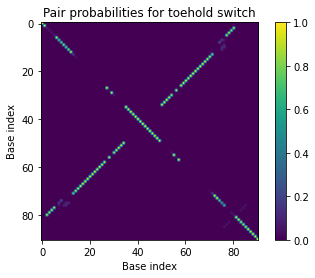

In [2]:
thsDisplay()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
trigger complex strand order and structure: 
['AUCGGCUAUAGCAGGCG', 'CGCCUGAAAAAAUAUAA', 'UUAUAGGCGGGAAGC']
By considering Boltzmann samples:  ..((.(((((.((((((+))))))...........+.))))).))......
By considering MFE structure:  .(((.((((((((((((+))))))...........+)))))).))).....  Free energy:  -25.68  (kcal/nol)
with these other possible structures: 
..((.(((((.((((((+))))))...........+.))))).))......
..((.((((((((((((+))))))...........+)))))).))......
..((.((((((((((((+))))))...........+)))))).))......
..((.((((((((((((+))))))...........+)))))).))......
..((.((((((((((((+))))))...........+)))))).))......
..((.((((((((((((+))))))...........+)))))).))......
..((.((((((((((((+))))))...........+)))))).))......
..((.((((((((((((+))))))...........+)))))).))......
.(((.(((((.((((((+))))))...........+.))))).))).....
.(((.(((((.((((((+))))))...........+.))))).))).....
CGCCUGAAAAAAUAUAA  is the and gate between  asd  ( AUCGG

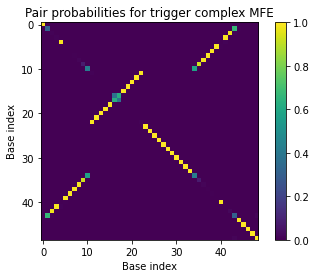

In [4]:
triggerDisplay()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
actiavted toehold switch structure: 
((((((((((((((((((((((((((.+.))))))))))))))))))))))))))...((((((....................))))))((........))..(((....))).....  Free energy:  -61.63  (kcal/mol)
with these other suboptimal energy structures: 
((((((((((((((((((((((((((.+.))))))))))))))))))))))))))...((((((....................))))))((........))..(((....))).....  Free energy:  -61.63  (kcal/mol)
((((((((((((((((((((((((((.+.))))))))))))))))))))))))))...((((((....................))))))((........))..(((....))).....  Free energy:  -61.63  (kcal/mol)
((((((((((((((((((((((((((.+.))))))))))))))))))))))))))...((((((....................))))))((........))..(((....))).....  Free energy:  -61.63  (kcal/mol)
((((((((((((((((((((((((((.+.))))))))))))))))))))))))))...((((((....................))))))((........))..(((....))).....  Free energy:  -61.63  (kcal/mol)
(((((((((((((((((((((((((((+)))))))))))))))))))))))))))...((((((.......

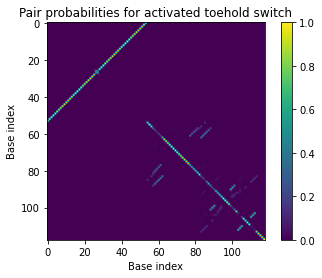

In [3]:
complexDisplay()